In [1]:
import math
import random
import numpy as np
import sys

# Data input stream simulation

In [2]:
class DataStream:
    def __init__(self, n=0, arr=None):
        self.arr = arr
        if arr is not None:
            self.n = len(arr)
        else:
            self.n = n
    
    def stream(self, k, r=1):
        i = 0
        while i < k and self.n > 0:
            if self.arr is None:
                t = np.random.rand(min(r, self.n))
            else:
                idx = min(r, self.n)
                t = np.array(self.arr[:idx])
                self.arr = self.arr[idx:]
            i += 1
            self.n -= r
            yield t
            
    def stream_ended(self):
        if self.n <= 0:
            return True
        else:
            return False

# MRL99 implementation

In [3]:
class MRL99:
    def __init__(self, b, r, k, h, inf=1e14):
        # init parameters
        self.b = b
        self.k = k
        self.r = r
        self.h = h
        self.maxh = self.h - 1
        # init buffers
        self.buffer = [[] for i in range(self.b)]
        self.buffer_empty = [True for i in range(self.b)]
        self.buffer_height = [0 for i in range(self.b)]
        self.buffer_weight = [0 for i in range(self.b)]
        # some value substituting the infinite
        self.inf = inf
        self.min_l = 0
        self.inp = None
        self.mem = 0
        
    def reset(self):
        self.maxh = self.h - 1
        # init buffers
        self.buffer = [[] for i in range(self.k)]
        self.buffer_empty = [True for i in range(self.b)]
        self.buffer_height = [0 for i in range(self.b)]
        self.buffer_weight = [0 for i in range(self.b)]
        self.min_l = 0
        self.inp = None
        self.mem = 0
    
    def new(self, buffer_idx, height=0):
        # select randomly k elements
        elements = []
        s = self.inp.stream(self.k, self.r)
        for el in s:
            elements.append(np.random.choice(el))
        # if there is less than k elements append inf
        while len(elements) < self.k:
            elements.append(self.inf)
            elements.append(-1 * self.inf)
        # update buffer states
        self.buffer[buffer_idx] = sorted(elements)
        self.buffer_weight[buffer_idx] = 1
        self.buffer_empty[buffer_idx] = False
        self.buffer_height[buffer_idx] = height
        if height < self.min_l:
            self.min_l = height
    
    def collapse(self, buffer_ids):
        # calculate weight
        W = sum([self.buffer_weight[i] for i in buffer_ids])
        # calculate offset
        idx = int(W / 2) if W % 2 == 0 else int((W + 1) / 2)
        # fill the new elements
        i = 0
        elements = []
        while len(elements) < self.k:
            min_idx = -1
            min_val = self.inf
            for j in buffer_ids:
                if len(self.buffer[j]) > 0:
                    if self.buffer[j][0] < min_val:
                        min_val = self.buffer[j][0]
                        min_idx = j
            self.buffer[min_idx].pop(0)
            i += self.buffer_weight[min_idx]
            if i > idx:
                elements.append(min_val)
                idx += W
        # update buffer states
        buffer_idx = buffer_ids[0]
        self.buffer[buffer_idx] = elements
        self.buffer_empty[buffer_idx] = False
        self.buffer_weight[buffer_idx] = W
        self.buffer_height[buffer_idx] = self.min_l + 1
        self.min_l += 1
        # update r if max height reached
        if self.min_l > self.maxh:
            self.maxh = self.min_l
            self.r = self.r * 2
        # empty buffers
        for i in buffer_ids[1:]:
            self.buffer_empty[i] = True
            self.buffer[i] = []
            self.buffer_height[i] = 0
            self.buffer_weight[i] = 0
    
    def output(self, q):
        if q < 0 or q > 1:
            raise Exception('Percentile value should be in range [0; 1]')
        # find needed index
        buffer_ids = [i for i in range(self.b) if not self.buffer_empty[i]]
        W = sum([self.buffer_weight[i] for i in buffer_ids])
        idx = int(math.ceil(q * self.k * W))
        # find the element corresponding to the quantile
        i = 0
        while i <= idx:
            min_idx = -1
            min_val = self.inf
            for j in buffer_ids:
                if len(self.buffer[j]) > 0:
                    if self.buffer[j][0] < min_val:
                        min_val = self.buffer[j][0]
                        min_idx = j
            self.buffer[min_idx].pop(0)
            i += self.buffer_weight[min_idx]
            if i > idx:
                return min_val
            
    def calculate_percentile(self, inp, q):
        self.reset()
        self.inp = inp
        while not self.inp.stream_ended():
            # new if 1 buffer is empty
            if sum(self.buffer_empty) == 1:
                idx = -1
                for i in range(self.b):
                    if self.buffer_empty[i]:
                        idx = i
                        break
                self.new(idx, self.min_l)
                mem = sys.getsizeof(self.buffer)
                if mem > self.mem:
                    self.mem = mem
            # new if more than one buffer is empty
            elif sum(self.buffer_empty) > 1:
                for i in range(self.b):
                    if self.buffer_empty[i]:
                        if not self.inp.stream_ended():
                            self.new(i)
                        else:
                            break
                mem = sys.getsizeof(self.buffer)
                if mem > self.mem:
                    self.mem = mem
            # collapse if possible
            else:
                buffer_ids = [i for i in range(self.b) if (self.buffer_height[i] == self.min_l and not self.buffer_empty[i])]
                if len(buffer_ids) > 1:
                    self.collapse(buffer_ids)
                else:
                    break
        # output when no other operations are available
        return self.output(q)

# Compare the results with the numpy.quantile

In [4]:
b = 6
k = 215
r = 2
h = 5

In [5]:
mrl99 = MRL99(b=b, r=r, k=k, h=h)

a = np.random.rand(100000)
stream = DataStream(arr=a)
quantile = mrl99.calculate_percentile(stream, 0.25)
print(f'MRL99 approximation: {quantile}')
print(f'Numpy approximation: {np.quantile(a, 0.25)}')
print()

a = np.random.randn(100000)
stream = DataStream(arr=a)
quantile = mrl99.calculate_percentile(stream, 0.25)
print(f'MRL99 approximation: {quantile}')
print(f'Numpy approximation: {np.quantile(a, 0.25)}')
print()

a = np.random.randint(-100, 100, size=100000)
stream = DataStream(arr=a)
quantile = mrl99.calculate_percentile(stream, 0.25)
print(f'MRL99 approximation: {quantile}')
print(f'Numpy approximation: {np.quantile(a, 0.25)}')
print()

MRL99 approximation: 0.2502310057604078
Numpy approximation: 0.24931940299011962

MRL99 approximation: -0.6741301685921832
Numpy approximation: -0.6710506289520288

MRL99 approximation: -50
Numpy approximation: -51.0



# Compare execution time with the growth of N

In [6]:
import psutil
from time import time

In [7]:
import matplotlib.pyplot as plt

In [8]:
b = 6
k = 215
r = 2
h = 5

mrl99 = MRL99(b=b, r=r, k=k, h=h)

In [9]:
times = []
for n in np.logspace(3, 9, num=7):
    t_avg = 0
    for i in range(10):
        a = np.random.rand(int(n))
        stream = DataStream(arr=a)
        start = time()
        quantile = mrl99.calculate_percentile(stream, 0.25)
        end = time()
        t_avg += end - start
    times.append(t_avg / 10)
    print(f'{n} done')

1000.0 done
10000.0 done
100000.0 done
1000000.0 done
10000000.0 done
100000000.0 done
1000000000.0 done


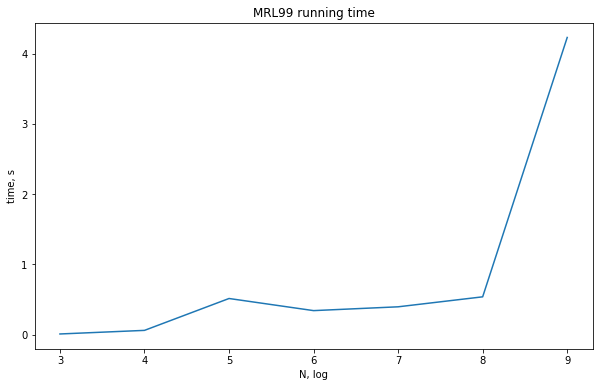

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(3, 10), times)
plt.xlabel('N, log')
plt.ylabel('time, s')
plt.title('MRL99 running time')
plt.show()

# Compare memory consumption with the error

In [11]:
errors = [0.1, 0.01, 0.001, 0.0001]
memory = []
for e in errors:
    r = 2
    h = math.ceil(np.log(1 / e))
    b = h + 1
    k = math.ceil(1 / e * np.sqrt(h))
    mrl99 = MRL99(b=b, r=r, k=k, h=h)
    a = np.random.rand(100000)
    stream = DataStream(arr=a)
    quantile = mrl99.calculate_percentile(stream, 0.25)
    memory.append(mrl99.mem)

In [12]:
memory.reverse()

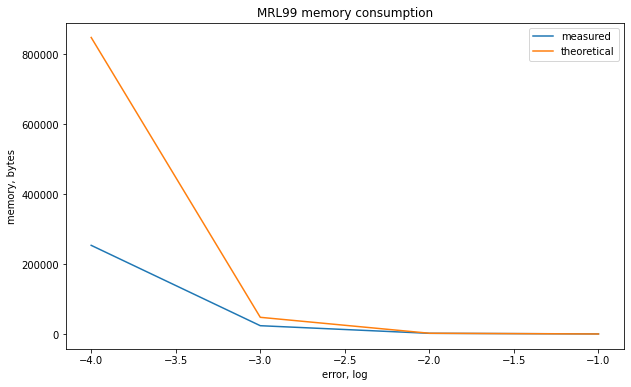

In [13]:
lbls = [1 / e * (np.log(1 / e) ** 2) for e in errors]
lbls.reverse()

plt.figure(figsize=(10, 6))
plt.plot(range(-4, 0), memory, label='measured')
plt.plot(range(-4, 0), lbls, label='theoretical')
plt.xlabel('error, log')
plt.ylabel('memory, bytes')
plt.title('MRL99 memory consumption')
plt.legend()
plt.show()